In [1]:
import sys
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
#from solvers.explicit_Euler import integrate
from solvers.gpu import integrate
#from solvers.explicit_Adams_Bashforth import integrate
#from solvers.turing_models import Brusselator
from solvers.turing_models_gpu import Brusselator_GPU

In [24]:
n = (128, 128)
L = (1, 1)


D_u = .02
D_v = .4
Ds = np.array([D_u, D_v])
A = 2
B = 3

c0 = np.random.normal(scale=.1, size=(2, n[0], n[1]))
c0[0, :, :] += A
c0[1, :, :] += B/A

f_args = (A, B)
t = np.linspace(0, 128, 64)
dt = 0.004

In [6]:
from solvers.gpu import create_GPU

In [8]:
 RHS_GPU

In [9]:
sol = integrate(c0, t, dt, n, L, Ds, Brusselator_GPU, f_args, 1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'f': cannot determine Numba type of <class 'numba.cuda.compiler.Dispatcher'>

File "turing_codebase/solvers/gpu.py", line 63:
    def RHS_GPU(c0, n, L, Ds, f_args, dc):
        <source elided>

        fuv = f(c0[:, x, y], f_args, z)
        ^


In [4]:
from matplotlib import pyplot as plt

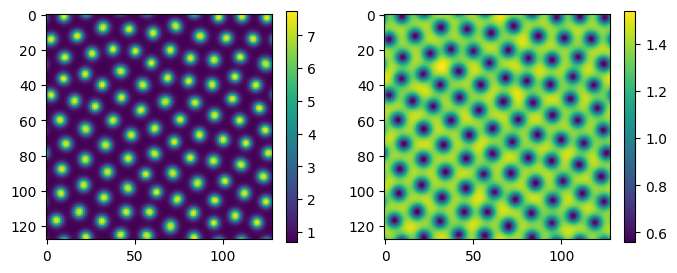

In [5]:
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow( sol[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

In [30]:
n = (128, 128)
L = (1, 1)


D_u = .02
D_v = .4
Ds = np.array([D_u, D_v])
A = 2
B = 3

c0 = np.random.normal(scale=.1, size=(2, n[0], n[1]))
c0[0, :, :] += A
c0[1, :, :] += B/A

f_args = (A, B)
t = np.linspace(0, 128*40, 128*40)
dt = 0.004

In [ ]:
sol = integrate(c0, t, dt, n, L, Ds, Brusselator_GPU, f_args, 1)

In [9]:
diff_2 = (sol[..., :-1]-sol[..., 1:])
max_diff = np.max(diff_2, axis=(0,1,2))

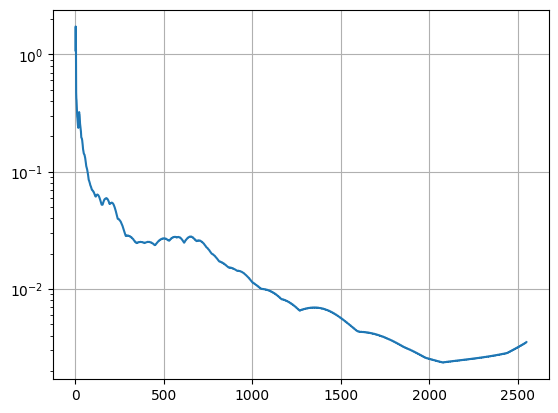

In [10]:
plt.plot(max_diff[10:])
plt.yscale('log')
plt.grid()
plt.show()

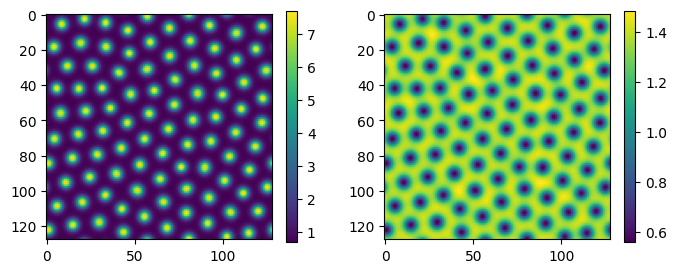

In [11]:
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow( sol[0,:,:, index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(sol[1,:,:, index])
plt.colorbar(shrink=.75)
plt.show()

In [9]:
from numba import cuda, float32
import numpy as np
import math


def integrate(c0, t, dt, n, L, Ds, f, f_args, order):
    threadsperblock = (2, 4, 4)
    blockspergrid_x = math.ceil(c0.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(c0.shape[1] / threadsperblock[1])
    blockspergrid_z = math.ceil(c0.shape[2] / threadsperblock[2])

    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

    ret = np.zeros((c0.shape[0], c0.shape[1], c0.shape[2], t.shape[0]))

    d_n = cuda.to_device(n)
    d_L = cuda.to_device(L)
    d_Ds = cuda.to_device(Ds)
    d_f_args = cuda.to_device(f_args)
    d_ret = cuda.to_device(ret)
    d_c = cuda.to_device(c0)

    d_dc_arr = define_dc(order, c0)
    t_c = t[0]
    assign_GPU[blockspergrid, threadsperblock](d_ret, d_c, 0)

    RHS_GPU = create_GPU(f)

    for i in range(1, order):
        RHS_GPU[blockspergrid, threadsperblock](d_c, d_n, d_L, d_Ds, d_f_args, d_dc_arr[i])
        forward_GPU(d_c, dt, blockspergrid, threadsperblock, i, *d_dc_arr[1 : i + 1])

    for t_i, t_next in enumerate(t[1:]):
        while t_c < t_next:
            RHS_GPU[blockspergrid, threadsperblock](d_c, d_n, d_L, d_Ds, d_f_args, d_dc_arr[0])
            forward_GPU(d_c, dt, blockspergrid, threadsperblock, order, *d_dc_arr)
            t_c += dt
            # Shift all the elements to left
            d_dc_arr = [d_dc_arr[-1]] + d_dc_arr[:-1]
        assign_GPU[blockspergrid, threadsperblock](d_ret, d_c, t_i + 1)
    d_ret.copy_to_host(ret)
    return ret


def create_GPU(f):
    @cuda.jit
    def RHS_GPU(c0, n, L, Ds, f_args, dc):
        
        def Brusselator_GPU(c0, f_args, z):
            A, B = f_args
            u = c0[0]
            v = c0[1]
            u2 = u**2
            u2v = u2 * v
            if z == 0:
                return A - (B + 1) * u + u2v
            else:
                return B * u - u2v


        z = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
        x = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        y = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
        if z >= c0.shape[0] or x >= c0.shape[1] or y >= c0.shape[2]:
            # Quit if (x, y) is outside of valid dc boundary
            return

        # Periodic boundary condition
        i_prev = (x - 1) % n[0]
        i_next = (x + 1) % n[0]

        j_prev = (y - 1) % n[1]
        j_next = (y + 1) % n[1]

        fuv = Brusselator_GPU(c0[:, x, y], f_args, z)

        dc[z, x, y] = (Ds[z] * n[z] / L[z]) * (
            c0[z, i_prev, y] + c0[z, i_next, y] + c0[z, x, j_prev] + c0[z, x, j_next] - 4.0 * c0[z, x, y]
        ) + fuv

    return RHS_GPU


@cuda.jit
def assign_GPU(cs, c, index):
    z = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    x = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    y = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
    if z >= c.shape[0] or x >= c.shape[1] or y >= c.shape[2]:
        # Quit if (x, y) is outside of valid dc boundary
        return
    cs[z, x, y, index] = c[z, x, y]


@cuda.jit
def forward_Euler_GPU(c, dt, dc):
    z = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    x = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    y = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
    if z >= c.shape[0] or x >= c.shape[1] or y >= c.shape[2]:
        # Quit if (x, y) is outside of valid dc boundary
        return
    c[z, x, y] += dc[z, x, y] * dt


In [10]:
def forward_GPU(c, dt, blockspergrid, threadsperblock, order, *d_dc):
    if order == 1:
        forward_Euler_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 2:
        backward_Adams_Moulton_2_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 3:
        backward_Adams_Moulton_3_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 4:
        backward_Adams_Moulton_4_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 5:
        backward_Adams_Moulton_5_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    else:
        assert False


def backward_GPU(c, dt, blockspergrid, threadsperblock, order, *d_dc):
    if order == 1:
        forward_Euler_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 2:
        forward_Adams_Bashforth_2_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 3:
        forward_Adams_Bashforth_3_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 4:
        forward_Adams_Bashforth_4_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    elif order == 5:
        forward_Adams_Bashforth_5_GPU[blockspergrid, threadsperblock](c, dt, *d_dc)
    else:
        assert False


def define_dc(order, c0):
    dc_1 = np.zeros_like(c0)
    d_dc_1 = cuda.to_device(dc_1)
    d_ret = [d_dc_1]

    def add_new(d_ret):
        dc_n = np.zeros_like(c0)
        d_dc_n = cuda.to_device(dc_n)
        d_ret += [d_dc_n]

    if order >= 2:
        add_new(d_ret)
    if order >= 3:
        add_new(d_ret)
    if order >= 4:
        add_new(d_ret)
    if order >= 5:
        add_new(d_ret)

    return d_ret

In [31]:
threadsperblock = (2, 4, 4)
blockspergrid_x = math.ceil(c0.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(c0.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(c0.shape[2] / threadsperblock[2])

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

ret = np.zeros((c0.shape[0], c0.shape[1], c0.shape[2], t.shape[0]))

d_n = cuda.to_device(n)
d_L = cuda.to_device(L)
d_Ds = cuda.to_device(Ds)
d_f_args = cuda.to_device(f_args)
d_ret = cuda.to_device(ret)
d_c = cuda.to_device(c0)

d_dc_arr = define_dc(1, c0)
t_c = t[0]
assign_GPU[blockspergrid, threadsperblock](d_ret, d_c, 0)

In [26]:
RHS_GPU = create_GPU(Brusselator_GPU)

In [27]:
for i in range(1, 1):
    RHS_GPU[blockspergrid, threadsperblock](d_c, d_n, d_L, d_Ds, d_f_args, d_dc_arr[i])
    forward_GPU(d_c, dt, blockspergrid, threadsperblock, i, *d_dc_arr[1 : i + 1])

In [32]:
for t_i, t_next in enumerate(t[1:]):
    while t_c < t_next:
        RHS_GPU[blockspergrid, threadsperblock](d_c, d_n, d_L, d_Ds, d_f_args, d_dc_arr[0])
        forward_GPU(d_c, dt, blockspergrid, threadsperblock, 1, *d_dc_arr)
        t_c += dt
        # Shift all the elements to left
        d_dc_arr = [d_dc_arr[-1]] + d_dc_arr[:-1]
    assign_GPU[blockspergrid, threadsperblock](d_ret, d_c, t_i + 1)
d_ret.copy_to_host(ret).shape

(2, 128, 128, 5120)

In [34]:
import numba
numba.__version__

'0.51.2'